In [3]:
import path
with path.Path('./Utils'):
    import constant as c
    import functions as f
import pandas as pd
import os
from os.path import join
from itertools import combinations
import numpy as np
from scipy.spatial.distance import euclidean, hamming
import collections

from numpy import matlib

import proxmin
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from joblib import dump, load

#3 Feature Scaling
import plotly.graph_objects as go
from sklearn.metrics import recall_score
from imblearn.metrics import specificity_score

%matplotlib inline


In [2]:
ant_dataframe = []
camel_dataframe = []
ivy_dataframe = []
jedit_dataframe = []
lucene_dataframe = []
poi_dataframe = []
synapse_dataframe = []
velocity_dataframe = []
xalan_dataframe = []
xerces_dataframe = []
log4j_dataframe = []


for filename in os.listdir(c.ant):
    tmp = pd.read_csv(join(c.ant, filename))
    ant_dataframe.append(tmp)

for filename in os.listdir(c.camel):
    tmp = pd.read_csv(join(c.camel, filename))
    camel_dataframe.append(tmp)
    
for filename in os.listdir(c.ivy):
    tmp = pd.read_csv(join(c.ivy, filename))
    ivy_dataframe.append(tmp)   
    
for filename in os.listdir(c.jedit):
    tmp = pd.read_csv(join(c.jedit, filename))
    jedit_dataframe.append(tmp)
    
for filename in os.listdir(c.lucene):
    tmp = pd.read_csv(join(c.lucene, filename))
    lucene_dataframe.append(tmp)
    
for filename in os.listdir(c.poi):
    tmp = pd.read_csv(join(c.poi, filename))
    poi_dataframe.append(tmp)
    
for filename in os.listdir(c.synapse):
    tmp = pd.read_csv(join(c.synapse, filename))
    synapse_dataframe.append(tmp)    
    
for filename in os.listdir(c.velocity):
    tmp = pd.read_csv(join(c.velocity, filename))
    velocity_dataframe.append(tmp)   
    
for filename in os.listdir(c.xalan):
    tmp = pd.read_csv(join(c.xalan, filename))
    xalan_dataframe.append(tmp)
    
for filename in os.listdir(c.xerces):
    tmp = pd.read_csv(join(c.xerces, filename))
    xerces_dataframe.append(tmp)

for filename in os.listdir(c.log4j):
    tmp = pd.read_csv(join(c.log4j, filename))
    log4j_dataframe.append(tmp)

    

ant_dataframe = pd.concat(ant_dataframe)
camel_dataframe = pd.concat(camel_dataframe)
ivy_dataframe = pd.concat(ivy_dataframe)
jedit_dataframe = pd.concat(jedit_dataframe)
lucene_dataframe = pd.concat(lucene_dataframe)
poi_dataframe = pd.concat(poi_dataframe)
synapse_dataframe = pd.concat(synapse_dataframe)
velocity_dataframe = pd.concat(velocity_dataframe)
xalan_dataframe = pd.concat(xalan_dataframe)
xerces_dataframe = pd.concat(xerces_dataframe)
log4j_dataframe = pd.concat(log4j_dataframe)

In [3]:
needed = ['name', 'wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']
features_withbug = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']
features = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc']


distances = ['e', 'm' , 'c']

In [4]:
all_dataframe = [
                ant_dataframe,
                camel_dataframe,
                ivy_dataframe,
                jedit_dataframe, 
                lucene_dataframe,
                poi_dataframe, 
                synapse_dataframe, 
                velocity_dataframe, 
                xalan_dataframe, 
                #xerces_dataframe,  #VA PRIMA ORDINATO (DA RICORDARE)
                log4j_dataframe
              ]

In [5]:
ant_dataframe
versions = ant_dataframe.version.unique()
names = ant_dataframe.name.unique()
version_tuple = [(x, y) for x, y in zip(versions[0::1],versions[1::1])]

In [6]:
import plotly.express as px


In [7]:
import warnings
warnings.filterwarnings('ignore') 

In [8]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy, predictions

def run_Regressor(previous, current, idx, ds3 = False,verbose = False, plot = False):
    """
        This function trains and uses model.

        :param D: matrix whose non-zero rows corresponds to the representatives of the dataset.
        :param p: norm to be used to calculate regularization cost.
        :returns: regularization cost.
    """

    scaler = StandardScaler()
    if ds3:
        training_D3 = previous.iloc[idx].reset_index()
        scaler.fit(training_D3[c.features])
        X_train = scaler.transform(training_D3[c.features])
        y_train = training_D3['bug']
        X_test = scaler.transform(current[c.features])
        y_test = current['bug']
    else:
        train = previous
        scaler.fit(train[c.features])
        X_train = scaler.transform(train[c.features])
        y_train = train['bug']
        X_test = scaler.transform(current[c.features])
        y_test = current['bug']
    
    # Create the random grid
    parameters = {
                    'n_estimators'      : [200, 300, 320,330,340],
                    'max_depth'         : [8, 9, 10, 11, 12],
                    'random_state'      : [0],
                    'max_features'      : ['auto', 'sqrt', 'log2']
                    #'max_features': ['auto'],
                    #'criterion' :['gini']
                }
    
    # Random search of parameters, 
    # search across 100 different combinations, and use all available cores
    clf = GridSearchCV(RandomForestClassifier(), 
                                parameters, cv= 10, n_jobs = -1)

    clf = clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.best_params_)
    y_predicted = clf.predict(X_test)
    
    ##CALCULATE SCORE OF THE MODEL##
    if plot:
        fig = px.scatter(y_test)
        fig.add_trace(go.Scatter(x= list(range(y_test.shape[0])), y= y_predicted))
        fig.show()
    
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print(classification_report(y_test, y_predicted))
    print()
    print()
        

    cm = metrics.confusion_matrix(y_test, y_predicted)
    gmean = geometric_mean_score(y_test, y_predicted, average = 'micro')
    #print(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    #TPR = TP / (TP + FN)
    TPR = recall_score(y_test, y_predicted, average='micro')

    # Fall out or false positive rate
    #FPR = FP / (FP + TN)
    FPR = 1 - (specificity_score(y_test, y_predicted, average='micro'))

    #Balance
    balance = 1 - (np.sqrt((0 - FPR) ** 2 + (1 - TPR) ** 2) / np.sqrt(2))
    balance = np.average(balance)

    ##F MEASURE##
    fmeasure = f1_score(y_test, y_predicted, average = 'micro')
    print('F-Measure : ', fmeasure)
    print('G-Mean :', gmean)
    print('Balance :', balance)
############################################################################
############################################################################
#    'micro':
#     Calculate metrics globally by counting the total true positives, false negatives and false positives.
#
#   'macro':
#     Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
############################################################################
############################################################################



    '''filename = join(c.MODEL_DIR , 'digits_classifier.joblib.pkl')
    _ = joblib.dump(clf, filename, compress=9)
'''

__________________________
PREVIOUS: 1.3
CURRENT: 1.4
DISTANCE: c
______WITH DS3_____
1.0
{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 0}


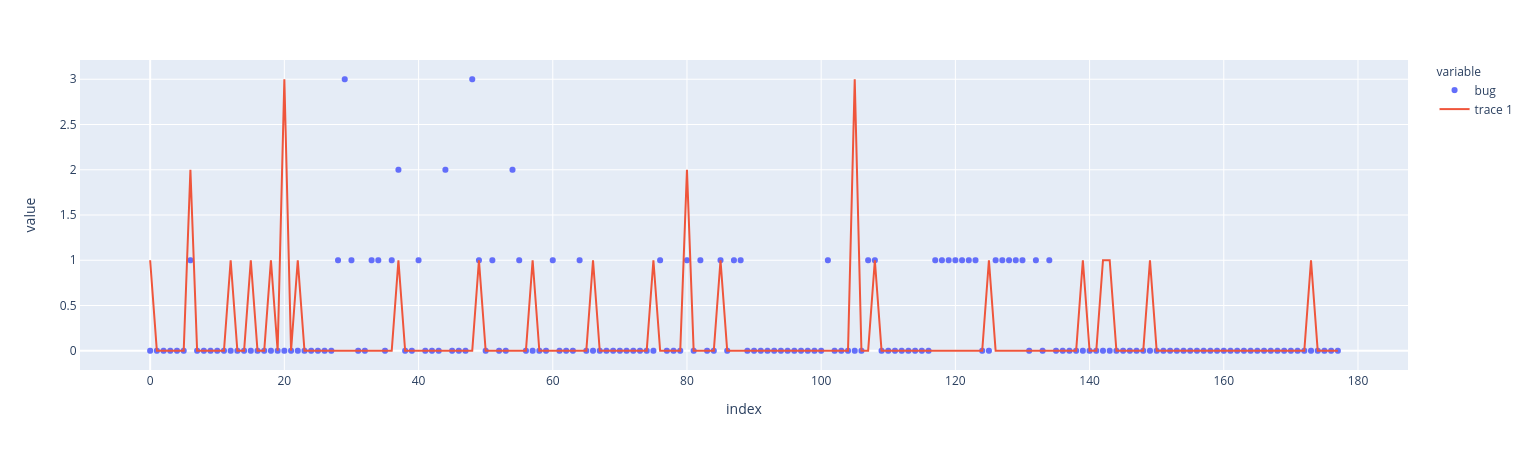


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       138
           1       0.17      0.09      0.11        35
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.70       178
   macro avg       0.24      0.24      0.24       178
weighted avg       0.64      0.70      0.67       178



F-Measure :  0.702247191011236
G-Mean : 0.7953291769880869
Balance : 0.7780681595365377
______WITHOUT DS3______
1.0
{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 330, 'random_state': 0}


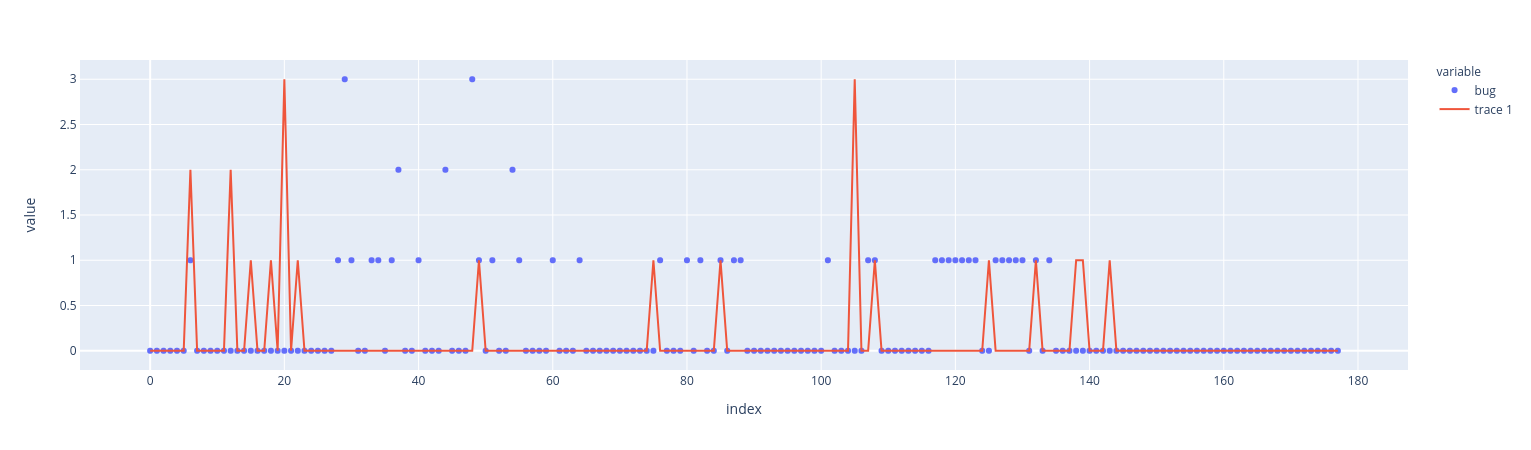


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       138
           1       0.33      0.11      0.17        35
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.74       178
   macro avg       0.28      0.26      0.25       178
weighted avg       0.67      0.74      0.69       178



F-Measure :  0.7359550561797754
G-Mean : 0.8192557510887808
Balance : 0.8031925188342882
__________________________
PREVIOUS: 1.4
CURRENT: 1.5
DISTANCE: c
______WITH DS3_____
0.9911504424778761
{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 340, 'random_state': 0}


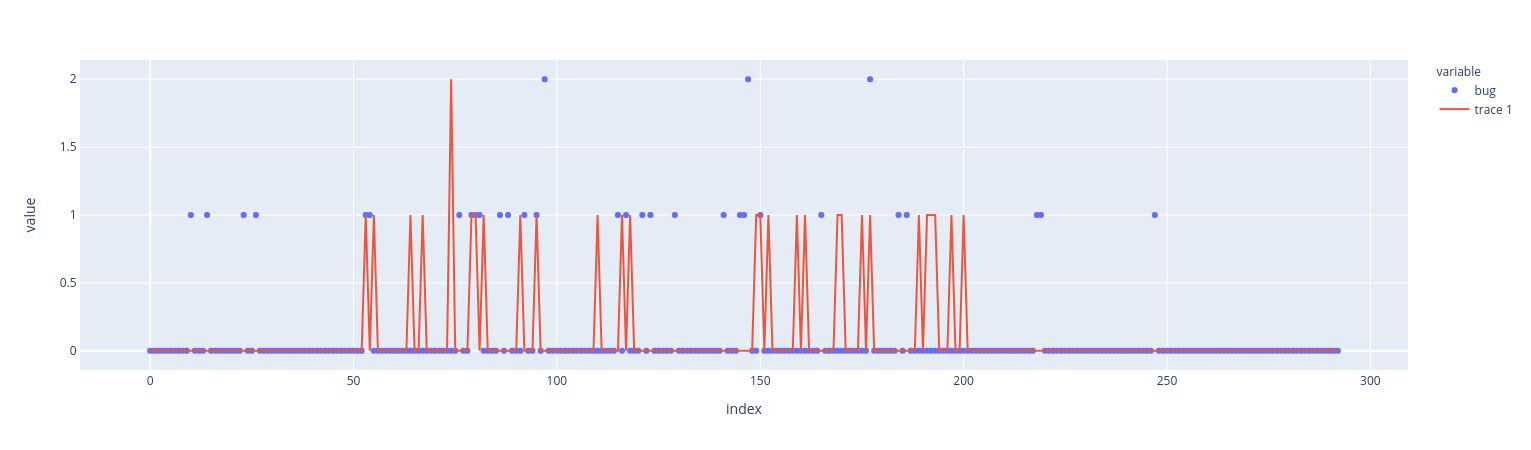


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       261
           1       0.19      0.17      0.18        29
           2       0.00      0.00      0.00         3

    accuracy                           0.83       293
   macro avg       0.36      0.36      0.36       293
weighted avg       0.82      0.83      0.83       293



F-Measure :  0.8327645051194539
G-Mean : 0.8735734731853706
Balance : 0.8677887326380114
______WITHOUT DS3______
0.9943820224719101
{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 0}


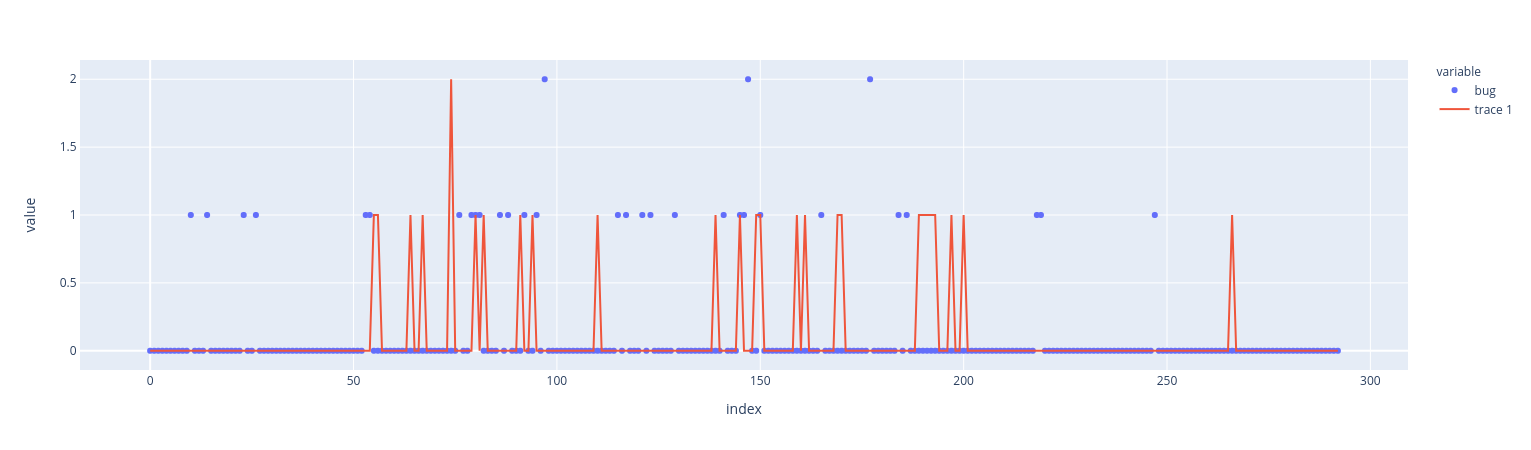


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       261
           1       0.12      0.10      0.11        29
           2       0.00      0.00      0.00         3

    accuracy                           0.82       293
   macro avg       0.34      0.34      0.34       293
weighted avg       0.81      0.82      0.81       293



F-Measure :  0.8225255972696246
G-Mean : 0.8657580364724826
Balance : 0.859694165248502
__________________________
PREVIOUS: 1.5
CURRENT: 1.6
DISTANCE: c
______WITH DS3_____
1.0
{'max_depth': 9, 'max_features': 'auto', 'n_estimators': 300, 'random_state': 0}


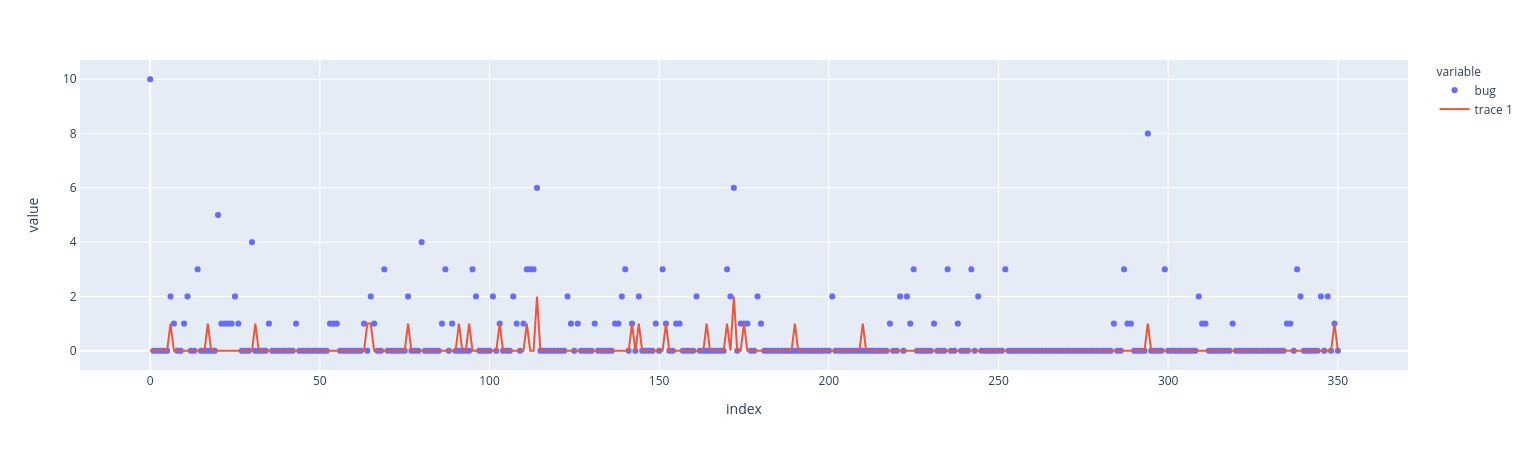


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       259
           1       0.25      0.11      0.15        46
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.73       351
   macro avg       0.11      0.12      0.11       351
weighted avg       0.60      0.73      0.65       351



F-Measure :  0.7293447293447293
G-Mean : 0.8394460107442916
Balance : 0.8071284448283154
______WITHOUT DS3______
1.0
{'max_depth': 11, 'max_features': 'auto'

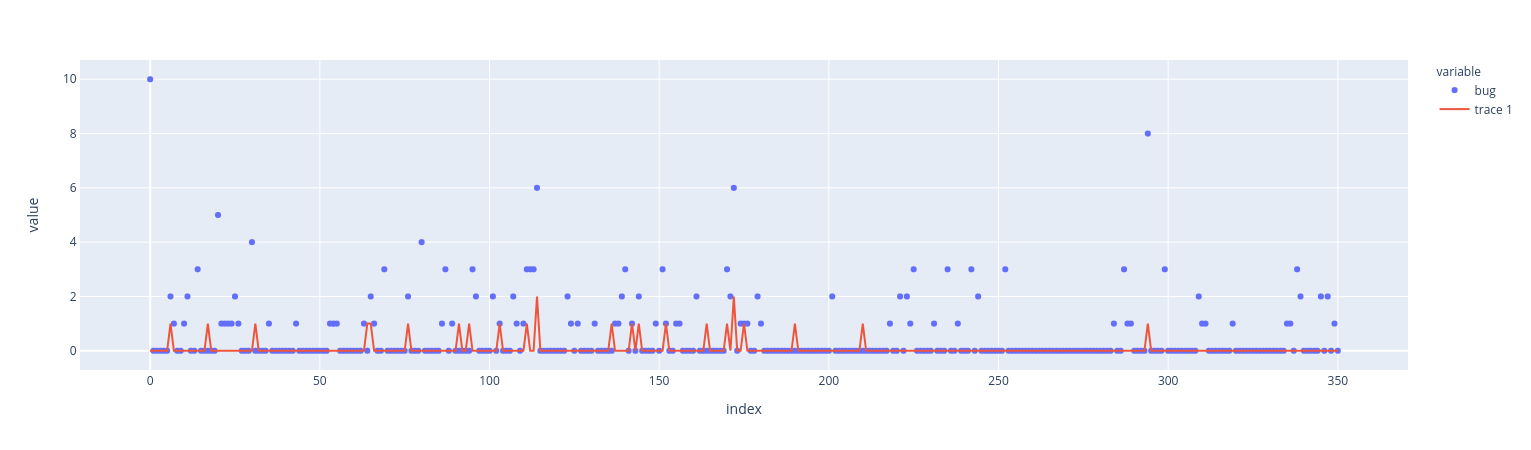


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       259
           1       0.20      0.09      0.12        46
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.72       351
   macro avg       0.11      0.12      0.11       351
weighted avg       0.59      0.72      0.64       351



F-Measure :  0.7236467236467236
G-Mean : 0.8358522332155743
Balance : 0.8030679910352273
__________________________
PREVIOUS: 1.6
CURRENT: 1.7
DISTANCE: c
__

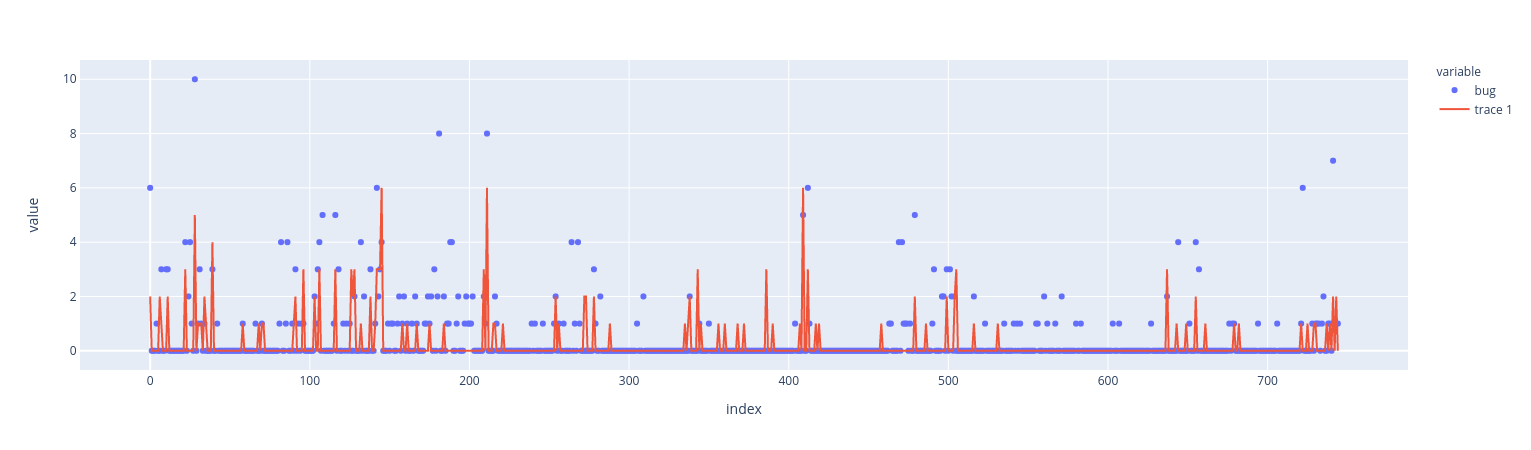


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       579
           1       0.29      0.15      0.20        93
           2       0.21      0.13      0.16        30
           3       0.07      0.06      0.06        16
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1

    accuracy                           0.75       745
   macro avg       0.14      0.13      0.13       745
weighted avg       0.69      0.75      0.72       745



F-Measure :  0.7543624161073825
G-Mean : 0.8566058333585088
Balance : 0.8252391147725263
______WITHOUT 

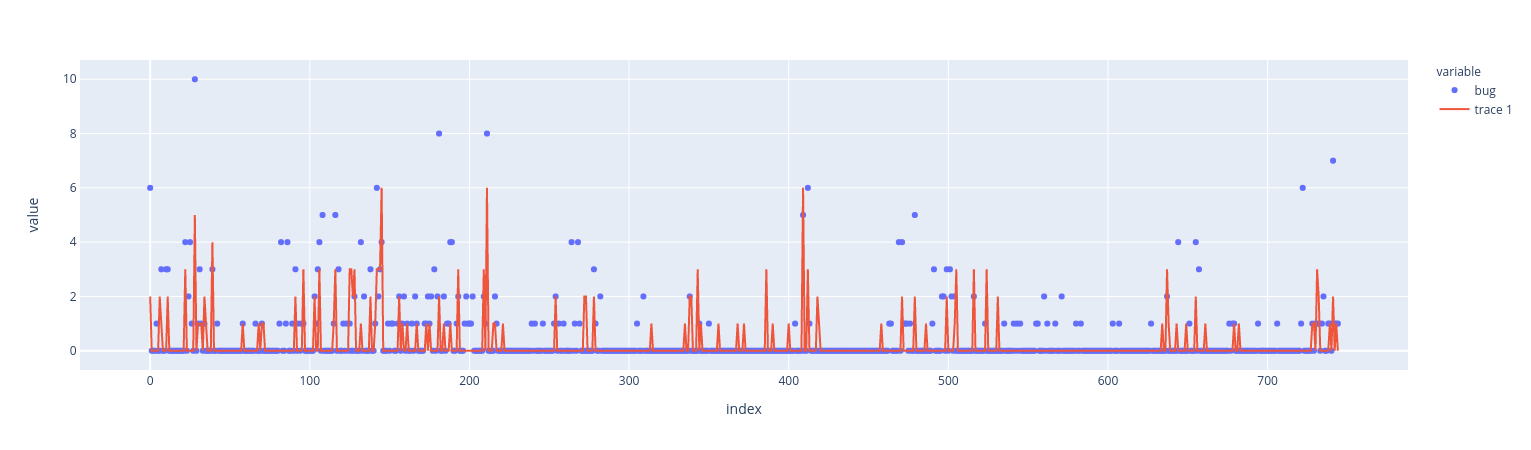


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.84      0.94      0.88       579
           1       0.33      0.16      0.22        93
           2       0.17      0.13      0.15        30
           3       0.05      0.06      0.06        16
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1

    accuracy                           0.76       745
   macro avg       0.14      0.13      0.13       745
weighted avg       0.70      0.76      0.72       745



F-Measure :  0.7570469798657719
G-Mean : 0.858260253759511
Balance : 0.8271490698023347


In [9]:
for v in version_tuple:
    print("__________________________")
    previous = ant_dataframe.loc[ant_dataframe.version == v[0]]
    current = ant_dataframe.loc[ant_dataframe.version == v[1]]
    previous = previous.sort_values('name').reset_index()
    current = current.sort_values('name').reset_index()
    previous = previous.drop(['index'], axis = 1)
    current = current.drop(['index'], axis = 1)
    modules_previous = previous.name.unique()
    modules_current = current.name.unique()
    for k in distances[-1]:
        print("PREVIOUS:", previous.version[0])
        print("CURRENT:", current.version[0])
        print("DISTANCE:", k)
        D = f.create_D(current, previous, features, k)
        idx = f.runDS3(D, reg = .5, verbose = False)
        print('______WITH DS3_____')
        run_Regressor(previous, current, idx, ds3 = True, verbose = True, plot = True )
        print('______WITHOUT DS3______')
        run_Regressor(previous, current, None, ds3 = False, verbose = True, plot = True )
        
 

In [10]:
current.bug[current.bug > 0]

0      6
4      1
7      3
10     3
11     3
      ..
739    1
741    7
742    1
743    1
744    1
Name: bug, Length: 166, dtype: int64